STAT 453: Deep Learning (Spring 2020)
Instructor: Sebastian Raschka (sraschka@wisc.edu)
- Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/ 
- GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

In [46]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [50]:
uploaded = files.upload()

Saving valid.csv to valid (1).csv


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link2 = 'https://drive.google.com/open?id=1Zanwf-bNXYt3UEAQxwBcdE7bpTPFXmz1'
fluff2, id2 = link2.split('=')

downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('png-files-kou2.zip')

In [0]:
!unzip  /content/png-files-kou2.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: png-files-kou2/002266.png  
  inflating: png-files-kou2/006000.png  
  inflating: png-files-kou2/009333.png  
  inflating: png-files-kou2/010662.png  
  inflating: png-files-kou2/000471.png  
  inflating: png-files-kou2/003150.png  
  inflating: png-files-kou2/013343.png  
  inflating: png-files-kou2/005521.png  
  inflating: png-files-kou2/015732.png  
  inflating: png-files-kou2/010892.png  
  inflating: png-files-kou2/001747.png  
  inflating: png-files-kou2/011554.png  
  inflating: png-files-kou2/006028.png  
  inflating: png-files-kou2/008005.png  
  inflating: png-files-kou2/007336.png  
  inflating: png-files-kou2/000459.png  
  inflating: png-files-kou2/006996.png  
  inflating: png-files-kou2/008763.png  
  inflating: png-files-kou2/007450.png  
  inflating: png-files-kou2/011232.png  
  inflating: png-files-kou2/001021.png  
  inflating: png-files-kou2/015054.png  
  inflating: png-files-kou2/002528.png  
  inflating: png-files-kou2/00

In [0]:
!ls

adc.json  __MACOSX	  png-files-kou2.zip  test.csv	 valid.csv
drive	  png-files-kou2  sample_data	      train.csv


- Runs on CPU (not recommended here) or GPU (if available)

# ResNet-34 Convolutional Neural Network

## Imports

In [0]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

## Settings and Dataset

In [0]:
class FashionMNISTDataset(Dataset):
    """Custom Dataset for loading FashionMNIST images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['image_name'].values
        self.y = df['class_label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [0]:
custom_transform1 = transforms.Compose([transforms.Resize([100,100]),
                                        transforms.ToTensor()])

train_dataset = FashionMNISTDataset(csv_path='train.csv',
                                    img_dir='png-files-kou2/',
                                    transform=custom_transform1)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1,
                          shuffle=False)

train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.3018, 0.2820, 0.2885])
Std Dev: tensor([0.2727, 0.2601, 0.2644])


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([32,32]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([32,32]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}

In [53]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 10
DEVICE = 'cuda:0' # default GPU device
BATCH_SIZE = 128
GRAYSCALE = False


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = FashionMNISTDataset(csv_path='train (1).csv',
                                    img_dir='png-files-kou2/',
                                    transform=data_transforms['train'])


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


valid_dataset = FashionMNISTDataset(csv_path='valid (1).csv',
                                    img_dir='png-files-kou2/',
                                    transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                         num_workers=4)


test_dataset = FashionMNISTDataset(csv_path='test (1).csv',
                                   img_dir='png-files-kou2/',
                                   transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                        num_workers=4)
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


## Model

In [0]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [0]:

##########################
### COST AND OPTIMIZER
##########################

model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [56]:
 NUM_EPOCHS = 10
 
 def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

    
minibatch_cost, epoch_cost = [], []
all_train_acc, all_valid_acc = [], []

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        valid_acc = compute_accuracy(model, valid_loader)
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, NUM_EPOCHS, train_acc, valid_acc))
        
        all_train_acc.append(train_acc)
        all_valid_acc.append(valid_acc)
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0102 | Cost: 2.7313
Epoch: 001/010 | Batch 0050/0102 | Cost: 1.9185
Epoch: 001/010 | Batch 0100/0102 | Cost: 2.0701
Epoch: 001/010 | Train: 29.316% | Valid: 28.365%
Time elapsed: 0.46 min
Epoch: 002/010 | Batch 0000/0102 | Cost: 1.8885
Epoch: 002/010 | Batch 0050/0102 | Cost: 1.8884
Epoch: 002/010 | Batch 0100/0102 | Cost: 2.0249
Epoch: 002/010 | Train: 32.352% | Valid: 29.893%
Time elapsed: 0.93 min
Epoch: 003/010 | Batch 0000/0102 | Cost: 1.8581
Epoch: 003/010 | Batch 0050/0102 | Cost: 1.8493
Epoch: 003/010 | Batch 0100/0102 | Cost: 1.8754
Epoch: 003/010 | Train: 33.944% | Valid: 30.182%
Time elapsed: 1.39 min
Epoch: 004/010 | Batch 0000/0102 | Cost: 1.7981
Epoch: 004/010 | Batch 0050/0102 | Cost: 1.8112
Epoch: 004/010 | Batch 0100/0102 | Cost: 1.8236
Epoch: 004/010 | Train: 34.871% | Valid: 29.149%
Time elapsed: 1.85 min
Epoch: 005/010 | Batch 0000/0102 | Cost: 1.5979
Epoch: 005/010 | Batch 0050/0102 | Cost: 1.7645
Epoch: 005/010 | Batch 0100/0102 | Cost:

In [57]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 24.94%


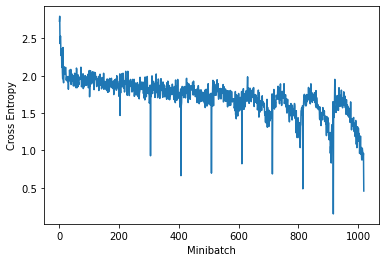

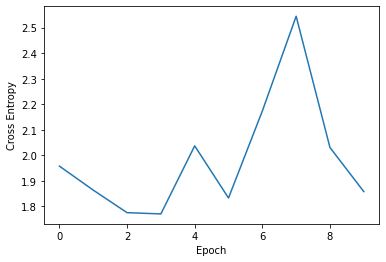

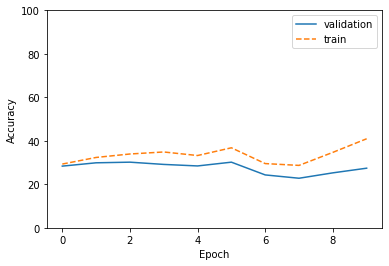

In [58]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
#plt.ylim([0, 2])
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
#plt.ylim([0, 2])
plt.show()


plt.plot(range(len(all_valid_acc)), all_valid_acc, label='validation')
plt.plot(range(len(all_train_acc)), all_train_acc, linestyle='--', label='train')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 100])
plt.legend()
plt.show()

In [59]:
model = resnet34(NUM_CLASSES)

model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

NUM_EPOCHS = 50

def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

minibatch_cost, epoch_cost = [], []
all_train_acc, all_test_acc = [], []

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, valid_loader)
        print('Epoch: %03d/%03d | Train: %.3f%% | Test: %.3f%%' % (
              epoch+1, NUM_EPOCHS, train_acc, test_acc))
        
        all_train_acc.append(train_acc)
        all_test_acc.append(test_acc)
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 0000/0102 | Cost: 3.3428
Epoch: 001/050 | Batch 0050/0102 | Cost: 1.9917
Epoch: 001/050 | Batch 0100/0102 | Cost: 2.0315
Epoch: 001/050 | Train: 30.297% | Test: 30.636%
Time elapsed: 0.47 min
Epoch: 002/050 | Batch 0000/0102 | Cost: 1.8687
Epoch: 002/050 | Batch 0050/0102 | Cost: 1.9071
Epoch: 002/050 | Batch 0100/0102 | Cost: 2.0060
Epoch: 002/050 | Train: 29.996% | Test: 27.457%
Time elapsed: 0.93 min
Epoch: 003/050 | Batch 0000/0102 | Cost: 1.8322
Epoch: 003/050 | Batch 0050/0102 | Cost: 1.8742
Epoch: 003/050 | Batch 0100/0102 | Cost: 1.9507
Epoch: 003/050 | Train: 33.295% | Test: 28.571%
Time elapsed: 1.40 min
Epoch: 004/050 | Batch 0000/0102 | Cost: 1.8364
Epoch: 004/050 | Batch 0050/0102 | Cost: 1.8258
Epoch: 004/050 | Batch 0100/0102 | Cost: 1.7679
Epoch: 004/050 | Train: 34.608% | Test: 29.562%
Time elapsed: 1.87 min
Epoch: 005/050 | Batch 0000/0102 | Cost: 1.7085
Epoch: 005/050 | Batch 0050/0102 | Cost: 1.7302
Epoch: 005/050 | Batch 0100/0102 | Cost: 1.7

In [60]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 32.64%


In [61]:
from mlxtend.evaluate import confusion_matrix

def compute_accuracy2(model, data_loader):
    model.eval()
    predictions = []
    target = []
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)

        predictions.append(predicted_labels)
        target.append(targets)
    return predictions,target

with torch.set_grad_enabled(False):
  pre,tar = compute_accuracy2(model, test_loader)

print(pre)

[tensor([1, 2, 6, 2, 6, 5, 3, 4, 2, 7, 2, 3, 4, 3, 2, 2, 6, 2, 3, 1, 3, 1, 2, 5,
        1, 1, 3, 1, 4, 3, 6, 6, 7, 5, 3, 6, 4, 3, 2, 3, 5, 6, 2, 2, 1, 1, 3, 1,
        2, 1, 1, 8, 8, 3, 1, 3, 5, 3, 2, 1, 3, 3, 3, 6, 2, 3, 3, 6, 2, 4, 1, 3,
        1, 3, 6, 4, 6, 4, 3, 2, 2, 2, 5, 4, 5, 1, 2, 2, 4, 5, 1, 1, 5, 1, 1, 3,
        3, 8, 2, 4, 1, 1, 3, 3, 1, 4, 5, 6, 1, 4, 3, 1, 4, 3, 3, 3, 2, 2, 1, 2,
        3, 1, 1, 2, 6, 1, 3, 1], device='cuda:0'), tensor([2, 4, 6, 1, 6, 3, 2, 3, 4, 2, 1, 7, 1, 3, 3, 2, 4, 5, 3, 1, 3, 1, 3, 2,
        8, 4, 3, 1, 2, 5, 2, 5, 1, 6, 1, 5, 2, 2, 3, 3, 3, 1, 3, 3, 1, 1, 3, 6,
        3, 1, 3, 8, 2, 3, 2, 3, 7, 2, 2, 2, 1, 4, 2, 5, 4, 6, 6, 6, 2, 4, 3, 1,
        3, 1, 4, 2, 2, 1, 6, 2, 1, 3, 2, 6, 2, 3, 3, 5, 1, 2, 5, 7, 4, 2, 4, 1,
        4, 5, 3, 3, 3, 2, 3, 4, 3, 4, 2, 5, 3, 2, 2, 6, 4, 3, 2, 6, 5, 1, 3, 4,
        5, 7, 2, 7, 2, 6, 3, 2], device='cuda:0'), tensor([4, 1, 1, 3, 4, 3, 2, 3, 2, 2, 3, 8, 1, 5, 3, 4, 1, 4, 1, 4, 4, 1, 6, 2,
        3, 3, 6, 

In [62]:
print(tar)

[tensor([2, 2, 6, 2, 6, 2, 2, 3, 6, 4, 2, 6, 4, 4, 2, 2, 6, 2, 2, 1, 3, 6, 2, 4,
        4, 4, 2, 1, 2, 2, 1, 4, 3, 9, 1, 6, 1, 4, 1, 2, 2, 3, 5, 2, 4, 2, 3, 1,
        2, 1, 6, 6, 1, 3, 1, 3, 3, 2, 3, 1, 1, 1, 1, 4, 1, 3, 3, 6, 3, 4, 1, 3,
        2, 1, 6, 3, 3, 3, 3, 4, 2, 7, 5, 4, 8, 1, 6, 2, 8, 2, 7, 6, 5, 3, 1, 5,
        4, 6, 4, 3, 3, 5, 3, 3, 2, 2, 2, 1, 2, 3, 2, 1, 4, 1, 6, 5, 7, 4, 1, 2,
        5, 2, 4, 1, 5, 8, 1, 6], device='cuda:0'), tensor([2, 4, 7, 2, 6, 1, 2, 2, 4, 1, 2, 3, 9, 3, 2, 5, 4, 3, 4, 7, 3, 6, 5, 2,
        8, 9, 9, 8, 9, 1, 2, 4, 2, 1, 1, 2, 2, 5, 1, 3, 3, 1, 3, 1, 6, 1, 6, 3,
        2, 4, 1, 1, 3, 2, 2, 7, 5, 1, 7, 3, 6, 4, 2, 3, 3, 5, 1, 3, 2, 4, 2, 7,
        3, 3, 1, 2, 4, 1, 8, 2, 1, 6, 2, 8, 4, 3, 4, 6, 3, 3, 1, 3, 8, 5, 2, 4,
        2, 2, 8, 1, 3, 4, 3, 3, 2, 3, 2, 1, 2, 8, 3, 3, 4, 3, 3, 1, 3, 4, 3, 3,
        2, 3, 6, 1, 2, 1, 3, 4], device='cuda:0'), tensor([6, 1, 6, 3, 2, 3, 2, 1, 2, 2, 3, 4, 1, 9, 6, 2, 1, 2, 1, 2, 2, 6, 6, 3,
        1, 4, 6, 

In [0]:
predictions = [1, 2, 6, 2, 6, 5, 3, 4, 2, 7, 2, 3, 4, 3, 2, 2, 6, 2, 3, 1, 3, 1, 2, 5,
        1, 1, 3, 1, 4, 3, 6, 6, 7, 5, 3, 6, 4, 3, 2, 3, 5, 6, 2, 2, 1, 1, 3, 1,
        2, 1, 1, 8, 8, 3, 1, 3, 5, 3, 2, 1, 3, 3, 3, 6, 2, 3, 3, 6, 2, 4, 1, 3,
        1, 3, 6, 4, 6, 4, 3, 2, 2, 2, 5, 4, 5, 1, 2, 2, 4, 5, 1, 1, 5, 1, 1, 3,
        3, 8, 2, 4, 1, 1, 3, 3, 1, 4, 5, 6, 1, 4, 3, 1, 4, 3, 3, 3, 2, 2, 1, 2,
        3, 1, 1, 2, 6, 1, 3, 1,2, 4, 6, 1, 6, 3, 2, 3, 4, 2, 1, 7, 1, 3, 3, 2, 4, 5, 3, 1, 3, 1, 3, 2,
        8, 4, 3, 1, 2, 5, 2, 5, 1, 6, 1, 5, 2, 2, 3, 3, 3, 1, 3, 3, 1, 1, 3, 6,
        3, 1, 3, 8, 2, 3, 2, 3, 7, 2, 2, 2, 1, 4, 2, 5, 4, 6, 6, 6, 2, 4, 3, 1,
        3, 1, 4, 2, 2, 1, 6, 2, 1, 3, 2, 6, 2, 3, 3, 5, 1, 2, 5, 7, 4, 2, 4, 1,
        4, 5, 3, 3, 3, 2, 3, 4, 3, 4, 2, 5, 3, 2, 2, 6, 4, 3, 2, 6, 5, 1, 3, 4,
        5, 7, 2, 7, 2, 6, 3, 2,4, 1, 1, 3, 4, 3, 2, 3, 2, 2, 3, 8, 1, 5, 3, 4, 1, 4, 1, 4, 4, 1, 6, 2,
        3, 3, 6, 7, 3, 1, 4, 1, 9, 3, 3, 3, 1, 1, 3, 8, 2, 2, 6, 3, 5, 1, 1, 2,
        3, 4, 3, 6, 2, 2, 6, 3, 8, 7, 6, 1, 2, 3, 5, 4, 4, 2, 4, 7, 2, 1, 1, 1,
        5, 3, 2, 4, 3, 1, 3, 8, 3, 1, 3, 4, 2, 1, 3, 4, 3, 4, 1, 6, 4, 3, 1, 2,
        4, 2, 2, 1, 3, 2, 3, 3, 2, 2, 3, 1, 4, 1, 2, 1, 2, 1, 4, 5, 2, 7, 4, 7,
        1, 3, 7, 7, 3, 3, 3, 2,1, 4, 6, 3, 2, 3, 3, 3, 7, 4, 7, 2, 3, 1, 1, 1, 2, 2, 1, 6, 5, 2, 6, 4,
        3, 1, 2, 6, 4, 5, 3, 4, 2, 1, 4, 5, 4, 6, 1, 2, 1, 1, 4, 1, 5, 2, 6, 3,
        1, 2, 1, 1, 5, 3, 1, 3, 3, 3, 2, 3, 4, 8, 2, 1, 1, 6, 1, 5, 3, 2, 1, 2,
        7, 1, 3, 8, 1, 4, 8, 9, 3, 2, 1, 3, 3, 2, 3, 1, 2, 3, 7, 2, 6, 4, 4, 7,
        2, 3, 4, 1, 3, 4, 3, 3, 2, 7, 1, 6, 2, 6, 3, 2, 5, 6, 1, 6, 7, 1, 3, 3,
        2, 1, 2, 3, 1, 2, 1, 2,6, 1, 4, 2, 1, 4, 3, 6, 1, 4, 3, 9, 6, 1, 3, 6, 1, 3, 4, 3, 5, 1, 3, 2,
        6, 2, 3, 3, 4, 3, 3, 2, 4, 1, 6, 3, 3, 3, 1, 1, 3, 2, 3, 3, 2, 3, 2, 4,
        3, 3, 4, 5, 4, 1, 1, 3, 3, 1, 1, 5, 1, 5, 3, 3, 3, 4, 3, 5, 2, 6, 1, 4,
        1, 5, 3, 1, 6, 7, 1, 3, 2, 6, 1, 3, 6, 4, 1, 8, 8, 3, 9, 3, 3, 5, 2, 4,
        1, 5, 2, 7, 3, 5, 1, 1, 3, 4, 1, 1, 5, 1, 4, 1, 2, 3, 1, 1, 1, 2, 1, 4,
        2, 3, 9, 1, 2, 5, 3, 3, 3, 1, 2, 3, 7, 3, 1, 7, 3, 2, 2, 2, 6, 3, 6, 2, 9, 4, 3, 1, 2, 3, 5, 2,
        5, 7, 2, 2, 5, 4, 6, 6, 1, 8, 2, 3, 1, 1, 1, 5, 2, 2, 1, 1, 1, 7, 3, 1,
        3, 1, 1, 2, 3, 3, 1, 3, 6, 6, 1, 4, 3, 3, 4, 3, 1, 1, 4, 4, 3, 1, 3, 3,
        4, 9, 3, 5, 3, 3, 3, 2, 1, 5, 3, 4, 2, 1, 3, 4, 3, 2, 3, 2, 3, 1, 5, 3,
        1, 3, 3, 4, 2, 4, 5, 3, 8, 4, 2, 2, 4, 1, 4, 4, 2, 2, 3, 6, 3, 9, 4, 1,
        3, 3, 1, 7, 1, 3, 3, 2, 2, 2, 1, 3, 6, 4, 6, 5, 1, 4, 1, 8, 1, 2, 3, 4, 4, 3, 1, 1, 3, 3, 1, 2,
        2, 8, 3, 1, 1, 1, 2, 4, 1, 3, 7, 1, 4, 1, 6, 2, 2, 1, 4, 4, 3, 4, 3, 3,
        3, 2]


In [0]:
targets = [2, 2, 6, 2, 6, 2, 2, 3, 6, 4, 2, 6, 4, 4, 2, 2, 6, 2, 2, 1, 3, 6, 2, 4,
        4, 4, 2, 1, 2, 2, 1, 4, 3, 9, 1, 6, 1, 4, 1, 2, 2, 3, 5, 2, 4, 2, 3, 1,
        2, 1, 6, 6, 1, 3, 1, 3, 3, 2, 3, 1, 1, 1, 1, 4, 1, 3, 3, 6, 3, 4, 1, 3,
        2, 1, 6, 3, 3, 3, 3, 4, 2, 7, 5, 4, 8, 1, 6, 2, 8, 2, 7, 6, 5, 3, 1, 5,
        4, 6, 4, 3, 3, 5, 3, 3, 2, 2, 2, 1, 2, 3, 2, 1, 4, 1, 6, 5, 7, 4, 1, 2,
        5, 2, 4, 1, 5, 8, 1, 6,2, 4, 7, 2, 6, 1, 2, 2, 4, 1, 2, 3, 9, 3, 2, 5, 4, 3, 4, 7, 3, 6, 5, 2,
        8, 9, 9, 8, 9, 1, 2, 4, 2, 1, 1, 2, 2, 5, 1, 3, 3, 1, 3, 1, 6, 1, 6, 3,
        2, 4, 1, 1, 3, 2, 2, 7, 5, 1, 7, 3, 6, 4, 2, 3, 3, 5, 1, 3, 2, 4, 2, 7,
        3, 3, 1, 2, 4, 1, 8, 2, 1, 6, 2, 8, 4, 3, 4, 6, 3, 3, 1, 3, 8, 5, 2, 4,
        2, 2, 8, 1, 3, 4, 3, 3, 2, 3, 2, 1, 2, 8, 3, 3, 4, 3, 3, 1, 3, 4, 3, 3,
        2, 3, 6, 1, 2, 1, 3, 4, 6, 1, 6, 3, 2, 3, 2, 1, 2, 2, 3, 4, 1, 9, 6, 2, 1, 2, 1, 2, 2, 6, 6, 3,
        1, 4, 6, 3, 3, 9, 3, 6, 5, 7, 3, 2, 3, 3, 3, 8, 2, 1, 3, 3, 2, 1, 6, 3,
        4, 5, 5, 1, 2, 1, 8, 3, 8, 1, 6, 3, 1, 1, 3, 1, 4, 2, 3, 8, 4, 1, 3, 6,
        7, 3, 2, 1, 4, 9, 3, 6, 1, 1, 2, 1, 4, 1, 1, 5, 3, 5, 3, 1, 3, 6, 4, 4,
        7, 1, 1, 4, 3, 2, 2, 3, 7, 3, 3, 6, 7, 3, 4, 8, 2, 6, 3, 5, 3, 2, 4, 4,
        2, 7, 1, 3, 4, 4, 1, 6,1, 2, 3, 3, 4, 3, 1, 2, 7, 2, 2, 2, 2, 2, 2, 4, 5, 5, 6, 6, 2, 6, 5, 2,
        3, 1, 3, 3, 2, 1, 2, 4, 4, 2, 1, 1, 3, 1, 6, 6, 1, 2, 6, 2, 5, 2, 2, 3,
        3, 5, 2, 4, 1, 3, 3, 2, 2, 4, 7, 4, 4, 6, 4, 6, 8, 1, 6, 2, 2, 2, 6, 3,
        7, 1, 2, 6, 5, 4, 1, 9, 8, 3, 5, 3, 3, 4, 2, 2, 2, 3, 3, 2, 6, 4, 4, 2,
        5, 3, 3, 3, 8, 4, 5, 3, 2, 7, 1, 9, 4, 1, 4, 6, 5, 1, 1, 5, 3, 7, 9, 7,
        4, 2, 3, 1, 3, 3, 1, 4,3, 6, 5, 4, 1, 3, 1, 1, 6, 8, 2, 9, 6, 9, 3, 6, 1, 7, 4, 3, 2, 1, 4, 3,
        6, 4, 3, 1, 1, 3, 1, 1, 4, 1, 1, 3, 3, 8, 3, 1, 3, 3, 1, 9, 2, 3, 3, 6,
        7, 3, 8, 6, 3, 9, 1, 4, 2, 3, 3, 1, 1, 1, 2, 4, 7, 2, 4, 1, 3, 3, 8, 1,
        3, 5, 3, 3, 6, 2, 1, 3, 2, 2, 3, 4, 6, 4, 3, 6, 1, 5, 6, 5, 7, 6, 9, 2,
        8, 1, 8, 4, 2, 2, 3, 1, 2, 4, 5, 1, 3, 5, 3, 3, 3, 3, 5, 6, 3, 5, 3, 2,
        3, 2, 3, 5, 6, 3, 1, 3, 4, 9, 3, 3, 7, 4, 1, 7, 4, 4, 2, 2, 6, 9, 6, 3, 4, 3, 3, 6, 2, 3, 8, 3,
        5, 3, 6, 3, 1, 4, 6, 6, 1, 7, 2, 1, 1, 6, 1, 3, 3, 3, 3, 3, 5, 8, 3, 3,
        3, 1, 1, 5, 3, 3, 1, 3, 3, 3, 3, 2, 8, 2, 3, 7, 1, 1, 1, 3, 5, 1, 3, 2,
        8, 5, 3, 4, 3, 1, 2, 3, 1, 1, 2, 2, 2, 2, 1, 3, 3, 5, 3, 6, 1, 1, 4, 3,
        1, 3, 1, 4, 3, 4, 3, 3, 4, 6, 3, 2, 4, 1, 3, 2, 2, 3, 6, 2, 3, 9, 4, 8,
        2, 8, 2, 3, 1, 6, 3, 3, 4, 9, 6, 4, 2, 3, 5, 2, 3, 2, 3, 1, 1, 2, 3, 4, 4, 9, 1, 3, 1, 3, 1, 2,
        4, 3, 2, 3, 3, 1, 2, 4, 1, 1, 5, 1, 1, 7, 2, 4, 1, 1, 4, 1, 7, 1, 3, 3,
        3, 4]

In [71]:
cm = confusion_matrix(y_target=targets, 
                      y_predicted=predictions, 
                      binary=False)
cm

array([[63, 12, 32, 12, 12, 14,  3,  5,  0],
       [20, 52, 37, 20, 13,  5,  4,  0,  0],
       [34, 33, 82, 24,  9, 12, 10,  1,  1],
       [11, 25, 22, 31,  4,  2,  3,  2,  1],
       [ 8, 11,  9,  4,  7,  5,  2,  0,  2],
       [25, 10,  8,  4,  3, 21,  0,  6,  1],
       [ 5,  5, 10,  2,  1,  1,  5,  1,  0],
       [ 7,  2,  6,  5,  2,  3,  2,  3,  0],
       [ 6,  3,  5,  1,  2,  1,  0,  0,  3]])

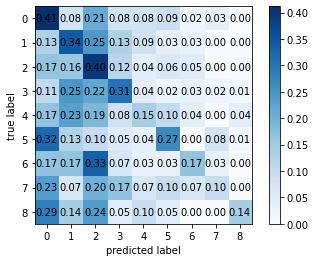

In [77]:
from mlxtend.plotting import plot_confusion_matrix
names = ['SUV','Coupe','Sedan','Convertible','Wagon','pick-up truck','Van','MPV','Mini Car']

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

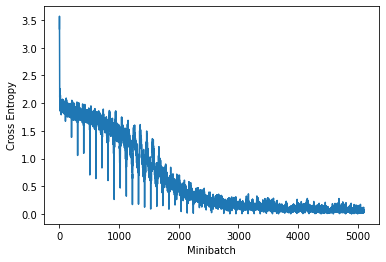

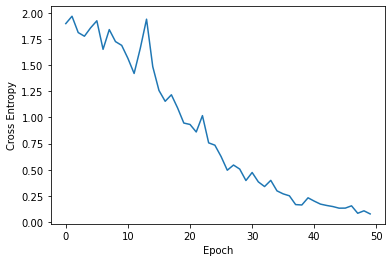

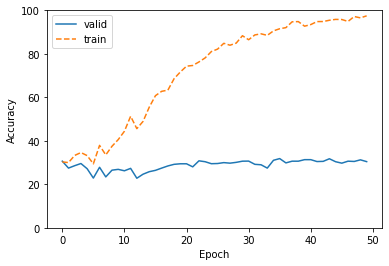

In [63]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
#plt.ylim([0, 2])
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
#plt.ylim([0, 2])
plt.show()


plt.plot(range(len(all_test_acc)), all_test_acc, label='valid')
plt.plot(range(len(all_train_acc)), all_train_acc, linestyle='--', label='train')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 100])
plt.legend()
plt.show()

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}



In [81]:
BATCH_SIZE = 128

train_dataset = FashionMNISTDataset(csv_path='train (1).csv',
                                    img_dir='png-files-kou2/',
                                    transform=data_transforms['train'])


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


valid_dataset = FashionMNISTDataset(csv_path='valid (1).csv',
                                    img_dir='png-files-kou2/',
                                    transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                         num_workers=4)


test_dataset = FashionMNISTDataset(csv_path='test (1).csv',
                                   img_dir='png-files-kou2/',
                                   transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                        num_workers=4)
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


In [82]:
from torchvision import models
model =models.resnet34(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
model.fc = nn.Sequential(
                      nn.Linear(512, NUM_CLASSES))

optimizer = torch.optim.Adam(model.parameters())

model = model.to(DEVICE)

NUM_EPOCHS = 10

def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/102 | Cost: 2.6522
Epoch: 001/010 Train Acc.: 45.94% | Validation Acc.: 42.98%
Time elapsed: 1.39 min
Epoch: 002/010 | Batch 000/102 | Cost: 1.5772
Epoch: 002/010 Train Acc.: 59.81% | Validation Acc.: 52.68%
Time elapsed: 2.76 min
Epoch: 003/010 | Batch 000/102 | Cost: 1.1748
Epoch: 003/010 Train Acc.: 66.91% | Validation Acc.: 53.14%
Time elapsed: 4.15 min
Epoch: 004/010 | Batch 000/102 | Cost: 0.8629
Epoch: 004/010 Train Acc.: 75.98% | Validation Acc.: 58.22%
Time elapsed: 5.52 min
Epoch: 005/010 | Batch 000/102 | Cost: 0.5776
Epoch: 005/010 Train Acc.: 82.53% | Validation Acc.: 60.90%
Time elapsed: 6.91 min
Epoch: 006/010 | Batch 000/102 | Cost: 0.5186
Epoch: 006/010 Train Acc.: 87.69% | Validation Acc.: 63.38%
Time elapsed: 8.29 min
Epoch: 007/010 | Batch 000/102 | Cost: 0.3735
Epoch: 007/010 Train Acc.: 90.01% | Validation Acc.: 62.10%
Time elapsed: 9.67 min
Epoch: 008/010 | Batch 000/102 | Cost: 0.2497
Epoch: 008/010 Train Acc.: 93.80% | Validation Acc.

## Evaluation

In [84]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, DEVICE)))

Test accuracy: 64.91%


In [89]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        print('pre:',predicted_labels)
        print('act:',targets)
    return correct_pred.float()/num_examples * 100


with torch.set_grad_enabled(False):
  compute_accuracy(model, test_loader, DEVICE)


pre: tensor([1, 3, 6, 2, 6, 2, 3, 3, 6, 4, 2, 6, 4, 4, 2, 3, 6, 4, 5, 1, 3, 6, 2, 4,
        2, 4, 2, 1, 2, 2, 1, 4, 3, 9, 1, 3, 1, 4, 1, 3, 4, 3, 5, 3, 2, 1, 3, 1,
        4, 1, 6, 6, 7, 3, 1, 3, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 3, 7, 2, 4, 1, 3,
        2, 5, 6, 3, 2, 4, 3, 4, 2, 7, 5, 4, 8, 1, 6, 2, 3, 3, 7, 6, 5, 3, 1, 2,
        2, 1, 4, 5, 5, 5, 2, 2, 2, 2, 2, 1, 4, 3, 2, 1, 4, 1, 6, 5, 6, 4, 1, 2,
        5, 2, 3, 1, 5, 7, 1, 6], device='cuda:0')
act: tensor([2, 2, 6, 2, 6, 2, 2, 3, 6, 4, 2, 6, 4, 4, 2, 2, 6, 2, 2, 1, 3, 6, 2, 4,
        4, 4, 2, 1, 2, 2, 1, 4, 3, 9, 1, 6, 1, 4, 1, 2, 2, 3, 5, 2, 4, 2, 3, 1,
        2, 1, 6, 6, 1, 3, 1, 3, 3, 2, 3, 1, 1, 1, 1, 4, 1, 3, 3, 6, 3, 4, 1, 3,
        2, 1, 6, 3, 3, 3, 3, 4, 2, 7, 5, 4, 8, 1, 6, 2, 8, 2, 7, 6, 5, 3, 1, 5,
        4, 6, 4, 3, 3, 5, 3, 3, 2, 2, 2, 1, 2, 3, 2, 1, 4, 1, 6, 5, 7, 4, 1, 2,
        5, 2, 4, 1, 5, 8, 1, 6], device='cuda:0')
pre: tensor([2, 4, 7, 1, 6, 3, 4, 2, 4, 1, 2, 3, 9, 3, 2, 2, 4, 3, 4, 7, 3, 6, 5, 1,
     

In [0]:
predictions = [1, 3, 6, 2, 6, 2, 3, 3, 6, 4, 2, 6, 4, 4, 2, 3, 6, 4, 5, 1, 3, 6, 2, 4,
        2, 4, 2, 1, 2, 2, 1, 4, 3, 9, 1, 3, 1, 4, 1, 3, 4, 3, 5, 3, 2, 1, 3, 1,
        4, 1, 6, 6, 7, 3, 1, 3, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 3, 7, 2, 4, 1, 3,
        2, 5, 6, 3, 2, 4, 3, 4, 2, 7, 5, 4, 8, 1, 6, 2, 3, 3, 7, 6, 5, 3, 1, 2,
        2, 1, 4, 5, 5, 5, 2, 2, 2, 2, 2, 1, 4, 3, 2, 1, 4, 1, 6, 5, 6, 4, 1, 2,
        5, 2, 3, 1, 5, 7, 1, 6,2, 4, 7, 1, 6, 3, 4, 2, 4, 1, 2, 3, 9, 3, 2, 2, 4, 3, 4, 7, 3, 6, 5, 1,
        1, 9, 9, 8, 1, 1, 2, 4, 2, 3, 1, 3, 2, 5, 3, 7, 3, 2, 2, 1, 3, 1, 3, 6,
        2, 1, 1, 1, 8, 2, 3, 7, 3, 1, 7, 1, 1, 4, 3, 3, 3, 5, 1, 3, 2, 2, 4, 1,
        3, 3, 8, 2, 5, 1, 1, 2, 1, 6, 4, 8, 4, 3, 2, 3, 8, 4, 1, 3, 3, 3, 4, 1,
        2, 3, 8, 4, 3, 2, 7, 7, 2, 3, 2, 1, 2, 8, 3, 3, 4, 3, 2, 1, 4, 3, 3, 6,
        3, 3, 1, 2, 3, 1, 6, 3, 6, 8, 6, 3, 4, 3, 2, 1, 2, 2, 3, 4, 1, 9, 5, 2, 1, 4, 1, 2, 2, 6, 6, 3,
        3, 4, 6, 3, 3, 1, 3, 6, 1, 4, 3, 3, 3, 3, 1, 8, 2, 1, 3, 3, 2, 1, 1, 3,
        4, 5, 3, 1, 2, 1, 2, 3, 8, 1, 1, 3, 1, 3, 1, 1, 2, 2, 3, 3, 4, 1, 3, 6,
        7, 3, 4, 2, 4, 9, 3, 1, 3, 8, 2, 2, 4, 1, 3, 5, 3, 4, 3, 1, 3, 3, 3, 2,
        7, 1, 1, 4, 3, 3, 3, 4, 3, 3, 3, 6, 2, 3, 4, 8, 2, 6, 9, 5, 3, 2, 4, 4,
        5, 1, 7, 1, 4, 3, 1, 6,1, 2, 3, 3, 4, 3, 1, 3, 7, 2, 2, 2, 2, 3, 2, 1, 5, 5, 1, 6, 2, 6, 5, 2,
        3, 1, 1, 3, 2, 1, 3, 4, 2, 2, 3, 1, 3, 4, 6, 6, 1, 3, 6, 2, 5, 6, 2, 3,
        3, 5, 3, 2, 1, 3, 1, 2, 2, 4, 7, 2, 3, 6, 2, 6, 1, 3, 1, 2, 3, 2, 6, 3,
        6, 1, 2, 6, 5, 4, 1, 9, 8, 7, 5, 8, 3, 2, 2, 4, 2, 3, 1, 4, 6, 4, 3, 2,
        5, 3, 3, 3, 8, 4, 5, 3, 2, 6, 3, 3, 2, 1, 2, 6, 5, 1, 1, 5, 1, 3, 9, 7,
        2, 2, 3, 1, 3, 3, 1, 4, 3, 6, 2, 2, 3, 4, 3, 1, 6, 8, 1, 9, 6, 1, 2, 6, 2, 1, 4, 3, 2, 1, 2, 1,
        6, 2, 3, 6, 8, 1, 1, 1, 4, 1, 1, 3, 3, 8, 3, 1, 3, 3, 3, 9, 4, 3, 3, 4,
        7, 6, 8, 1, 5, 9, 1, 4, 3, 1, 3, 1, 1, 1, 3, 3, 7, 2, 4, 1, 4, 2, 8, 1,
        3, 5, 3, 3, 6, 4, 3, 3, 2, 2, 1, 3, 6, 4, 3, 6, 1, 5, 6, 4, 9, 5, 9, 2,
        8, 1, 8, 5, 2, 5, 5, 1, 2, 1, 5, 1, 3, 5, 3, 5, 1, 3, 1, 6, 5, 9, 3, 3,
        3, 3, 2, 5, 6, 1, 3, 3, 4, 9, 3, 3, 7, 2, 1, 7, 3, 2, 2, 3, 7, 9, 6, 4, 4, 3, 3, 6, 2, 3, 8, 3,
        5, 3, 6, 3, 1, 2, 6, 6, 2, 3, 3, 3, 2, 6, 1, 3, 8, 3, 1, 3, 5, 8, 3, 2,
        3, 1, 5, 5, 3, 3, 1, 3, 3, 3, 3, 2, 8, 4, 3, 1, 5, 1, 3, 3, 3, 1, 3, 3,
        8, 3, 3, 1, 2, 3, 2, 3, 1, 1, 3, 5, 2, 1, 7, 3, 3, 5, 3, 3, 1, 1, 2, 2,
        1, 6, 1, 4, 3, 4, 3, 9, 2, 6, 3, 3, 4, 1, 2, 2, 1, 2, 6, 2, 3, 9, 4, 8,
        5, 3, 2, 1, 1, 3, 3, 3, 3, 4, 6, 4, 2, 3, 5, 3, 3, 5, 3, 1, 1, 3, 3, 2, 4, 9, 1, 1, 1, 4, 1, 7,
        4, 3, 4, 3, 3, 8, 2, 4, 1, 1, 4, 1, 1, 3, 6, 4, 1, 1, 3, 1, 3, 1, 7, 3,
        1, 4]

targets = [2, 2, 6, 2, 6, 2, 2, 3, 6, 4, 2, 6, 4, 4, 2, 2, 6, 2, 2, 1, 3, 6, 2, 4,
        4, 4, 2, 1, 2, 2, 1, 4, 3, 9, 1, 6, 1, 4, 1, 2, 2, 3, 5, 2, 4, 2, 3, 1,
        2, 1, 6, 6, 1, 3, 1, 3, 3, 2, 3, 1, 1, 1, 1, 4, 1, 3, 3, 6, 3, 4, 1, 3,
        2, 1, 6, 3, 3, 3, 3, 4, 2, 7, 5, 4, 8, 1, 6, 2, 8, 2, 7, 6, 5, 3, 1, 5,
        4, 6, 4, 3, 3, 5, 3, 3, 2, 2, 2, 1, 2, 3, 2, 1, 4, 1, 6, 5, 7, 4, 1, 2,
        5, 2, 4, 1, 5, 8, 1, 6,2, 4, 7, 2, 6, 1, 2, 2, 4, 1, 2, 3, 9, 3, 2, 5, 4, 3, 4, 7, 3, 6, 5, 2,
        8, 9, 9, 8, 9, 1, 2, 4, 2, 1, 1, 2, 2, 5, 1, 3, 3, 1, 3, 1, 6, 1, 6, 3,
        2, 4, 1, 1, 3, 2, 2, 7, 5, 1, 7, 3, 6, 4, 2, 3, 3, 5, 1, 3, 2, 4, 2, 7,
        3, 3, 1, 2, 4, 1, 8, 2, 1, 6, 2, 8, 4, 3, 4, 6, 3, 3, 1, 3, 8, 5, 2, 4,
        2, 2, 8, 1, 3, 4, 3, 3, 2, 3, 2, 1, 2, 8, 3, 3, 4, 3, 3, 1, 3, 4, 3, 3,
        2, 3, 6, 1, 2, 1, 3, 4, 6, 1, 6, 3, 2, 3, 2, 1, 2, 2, 3, 4, 1, 9, 6, 2, 1, 2, 1, 2, 2, 6, 6, 3,
        1, 4, 6, 3, 3, 9, 3, 6, 5, 7, 3, 2, 3, 3, 3, 8, 2, 1, 3, 3, 2, 1, 6, 3,
        4, 5, 5, 1, 2, 1, 8, 3, 8, 1, 6, 3, 1, 1, 3, 1, 4, 2, 3, 8, 4, 1, 3, 6,
        7, 3, 2, 1, 4, 9, 3, 6, 1, 1, 2, 1, 4, 1, 1, 5, 3, 5, 3, 1, 3, 6, 4, 4,
        7, 1, 1, 4, 3, 2, 2, 3, 7, 3, 3, 6, 7, 3, 4, 8, 2, 6, 3, 5, 3, 2, 4, 4,
        2, 7, 1, 3, 4, 4, 1, 6,1, 2, 3, 3, 4, 3, 1, 2, 7, 2, 2, 2, 2, 2, 2, 4, 5, 5, 6, 6, 2, 6, 5, 2,
        3, 1, 3, 3, 2, 1, 2, 4, 4, 2, 1, 1, 3, 1, 6, 6, 1, 2, 6, 2, 5, 2, 2, 3,
        3, 5, 2, 4, 1, 3, 3, 2, 2, 4, 7, 4, 4, 6, 4, 6, 8, 1, 6, 2, 2, 2, 6, 3,
        7, 1, 2, 6, 5, 4, 1, 9, 8, 3, 5, 3, 3, 4, 2, 2, 2, 3, 3, 2, 6, 4, 4, 2,
        5, 3, 3, 3, 8, 4, 5, 3, 2, 7, 1, 9, 4, 1, 4, 6, 5, 1, 1, 5, 3, 7, 9, 7,
        4, 2, 3, 1, 3, 3, 1, 4, 3, 6, 5, 4, 1, 3, 1, 1, 6, 8, 2, 9, 6, 9, 3, 6, 1, 7, 4, 3, 2, 1, 4, 3,
        6, 4, 3, 1, 1, 3, 1, 1, 4, 1, 1, 3, 3, 8, 3, 1, 3, 3, 1, 9, 2, 3, 3, 6,
        7, 3, 8, 6, 3, 9, 1, 4, 2, 3, 3, 1, 1, 1, 2, 4, 7, 2, 4, 1, 3, 3, 8, 1,
        3, 5, 3, 3, 6, 2, 1, 3, 2, 2, 3, 4, 6, 4, 3, 6, 1, 5, 6, 5, 7, 6, 9, 2,
        8, 1, 8, 4, 2, 2, 3, 1, 2, 4, 5, 1, 3, 5, 3, 3, 3, 3, 5, 6, 3, 5, 3, 2,
        3, 2, 3, 5, 6, 3, 1, 3,4, 9, 3, 3, 7, 4, 1, 7, 4, 4, 2, 2, 6, 9, 6, 3, 4, 3, 3, 6, 2, 3, 8, 3,
        5, 3, 6, 3, 1, 4, 6, 6, 1, 7, 2, 1, 1, 6, 1, 3, 3, 3, 3, 3, 5, 8, 3, 3,
        3, 1, 1, 5, 3, 3, 1, 3, 3, 3, 3, 2, 8, 2, 3, 7, 1, 1, 1, 3, 5, 1, 3, 2,
        8, 5, 3, 4, 3, 1, 2, 3, 1, 1, 2, 2, 2, 2, 1, 3, 3, 5, 3, 6, 1, 1, 4, 3,
        1, 3, 1, 4, 3, 4, 3, 3, 4, 6, 3, 2, 4, 1, 3, 2, 2, 3, 6, 2, 3, 9, 4, 8,
        2, 8, 2, 3, 1, 6, 3, 3,4, 9, 6, 4, 2, 3, 5, 2, 3, 2, 3, 1, 1, 2, 3, 4, 4, 9, 1, 3, 1, 3, 1, 2,
        4, 3, 2, 3, 3, 1, 2, 4, 1, 1, 5, 1, 1, 7, 2, 4, 1, 1, 4, 1, 7, 1, 3, 3,
        3, 4]

In [91]:

cm = confusion_matrix(y_target=targets, 
                      y_predicted=predictions, 
                      binary=False)
cm

array([[113,   7,  19,   2,   3,   1,   3,   5,   0],
       [  7,  86,  32,  17,   6,   2,   1,   0,   0],
       [ 18,  14, 144,   8,   6,   5,   5,   4,   2],
       [  5,  25,  13,  56,   2,   0,   0,   0,   0],
       [  2,   3,   5,   3,  34,   0,   0,   0,   1],
       [  9,   0,   7,   1,   2,  57,   2,   0,   0],
       [  4,   1,   5,   1,   0,   3,  15,   0,   1],
       [  3,   1,   4,   0,   0,   0,   1,  21,   0],
       [  3,   0,   1,   1,   0,   0,   0,   0,  16]])

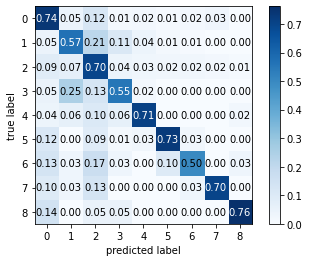

In [92]:
from mlxtend.plotting import plot_confusion_matrix
names = ['SUV','Coupe','Sedan','Convertible','Wagon','pick-up truck','Van','MPV','Mini Car']

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [117]:
model =models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [120]:
model.fc = nn.Sequential(
                      nn.Linear(2048, NUM_CLASSES))

optimizer = torch.optim.Adam(model.parameters())

model = model.to(DEVICE)

NUM_EPOCHS = 20

def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)

all_train_acc, all_valid_acc = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
        all_train_acc.append(train_acc)
        all_valid_acc.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/102 | Cost: 2.3378
Epoch: 001/020 Train Acc.: 48.06% | Validation Acc.: 43.27%
Time elapsed: 1.81 min
Epoch: 002/020 | Batch 000/102 | Cost: 1.4999
Epoch: 002/020 Train Acc.: 53.95% | Validation Acc.: 45.33%
Time elapsed: 3.61 min
Epoch: 003/020 | Batch 000/102 | Cost: 1.2457
Epoch: 003/020 Train Acc.: 59.83% | Validation Acc.: 47.19%
Time elapsed: 5.41 min
Epoch: 004/020 | Batch 000/102 | Cost: 1.0365
Epoch: 004/020 Train Acc.: 64.78% | Validation Acc.: 47.98%
Time elapsed: 7.21 min
Epoch: 005/020 | Batch 000/102 | Cost: 1.0471
Epoch: 005/020 Train Acc.: 68.80% | Validation Acc.: 44.67%
Time elapsed: 9.01 min
Epoch: 006/020 | Batch 000/102 | Cost: 0.7562
Epoch: 006/020 Train Acc.: 75.92% | Validation Acc.: 47.52%
Time elapsed: 10.80 min
Epoch: 007/020 | Batch 000/102 | Cost: 0.4717
Epoch: 007/020 Train Acc.: 82.06% | Validation Acc.: 49.59%
Time elapsed: 12.60 min
Epoch: 008/020 | Batch 000/102 | Cost: 0.4239
Epoch: 008/020 Train Acc.: 84.41% | Validation Ac

In [121]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, DEVICE)))

Test accuracy: 55.26%


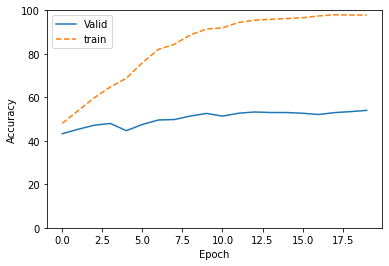

In [122]:
plt.plot(range(len(all_valid_acc)), all_valid_acc, label='Valid')
plt.plot(range(len(all_train_acc)), all_train_acc, linestyle='--', label='train')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 100])
plt.legend()
plt.show()